#### Yu Han, July 2023.
We used logistic regression to classify stem cells with deletion vs. w/o deletion. Feature importance score is printed. 

mann-whitney-u-test was adopted to run feature by feature analysis between the deletion group and the control group to find significant features.

Combining morph features and branching features.

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import math
import statistics
import random
import scipy.stats as ss

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit

import warnings
warnings.filterwarnings("ignore")
from pycytominer import aggregate
from parse_cp_features import parse_cp_features

### logistic regression

In [2]:
#read morph feature profile data of two plates 
df_stem=pd.read_csv('../1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized_variable_selected.csv.gz')
#remove 23, 24, 25, 26 from Metadata_LINE_ID
#remove isogenic cell lines
df_stem=df_stem[~df_stem.Metadata_line_ID.isin([23,24,25,26])]
df_stem.head(2)

,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_ID,Metadata_line_condition,Metadata_line_source,Cells_AreaShape_Center_X,...,Nuclei_Texture_InfoMeas1_RNA_10_03,Nuclei_Texture_InfoMeas2_Brightfield_20_00,Nuclei_Texture_InfoMeas2_ER_10_03,Nuclei_Texture_InfoMeas2_RNA_10_03,Nuclei_Texture_InfoMeas2_RNA_20_01,Nuclei_Texture_InverseDifferenceMoment_ER_20_02,Nuclei_Texture_SumAverage_Brightfield_20_03,Nuclei_Texture_SumEntropy_Brightfield_20_01,Nuclei_Texture_SumVariance_DNA_20_03,Nuclei_Texture_SumVariance_Mito_10_00
0,BR_NCP_STEM_1,A01,BR_NCP_STEM_1,BR_NCP_STEM_1,A01,10000,1,control,human,0.50933,...,-0.90823,1.56270,1.1817,0.17543,0.000126,-0.89288,0.630330,0.63990,2.8473,0.82266
1,BR_NCP_STEM_1,A02,BR_NCP_STEM_1,BR_NCP_STEM_1,A02,10000,1,control,human,-0.31877,...,-1.63920,0.65012,1.2649,1.45140,0.280320,-1.23480,-0.062683,-0.26259,2.7774,0.43155


In [3]:
#save df_stem as csv
df_stem.to_csv('profile/stem_morph.csv', index=False)

In [4]:
#code deletion as 1 and control as 0. 
df_stem.Metadata_line_condition[df_stem.Metadata_line_condition == 'deletion'] = 1
df_stem.Metadata_line_condition[df_stem.Metadata_line_condition == 'control'] = 0

In [5]:
#select all feature columns
df_stem_feature=df_stem.loc[:,~df_stem.columns.str.startswith('Metadata')]

In [6]:
### logistic regression 
#define X and y
X=df_stem_feature.values
y=df_stem['Metadata_line_condition'].tolist()
y0=np.array(y)

#split training and testing 
#using GroupShuffleSplit to ensure the same patient won't appear in train and test set at the same time
gss = GroupShuffleSplit(n_splits=2, train_size=.8, random_state=42)
gss.get_n_splits()
for train_idx, test_idx in gss.split(X, y0, df_stem['Metadata_line_ID']):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y0[train_idx], y0[test_idx]

#fit the model
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)

#print acc score
score = logisticRegr.score(X_test, y_test)
score

0.8472222222222222

In [7]:
#print feature importance values
stem_feature_weights = pd.DataFrame(logisticRegr.coef_[0], columns=['weight'], index=df_stem_feature.columns)
stem_feature_weights.reindex(stem_feature_weights['weight'].abs().sort_values(ascending=False).index).head(10)

,weight
Cytoplasm_Intensity_MADIntensity_ER,0.431595
Nuclei_Correlation_Costes_Mito_AGP,-0.421390
Cytoplasm_Texture_AngularSecondMoment_ER_5_03,-0.384761
Cytoplasm_Granularity_1_ER,-0.373265
Cytoplasm_RadialDistribution_FracAtD_Brightfield_1of4,0.370366
Cytoplasm_Texture_InverseDifferenceMoment_ER_5_00,-0.324206
Nuclei_Correlation_Correlation_DNA_Brightfield,0.322219
Nuclei_RadialDistribution_RadialCV_DNA_2of4,-0.319861
Cytoplasm_Texture_Correlation_AGP_10_01,0.319215
Nuclei_Correlation_Overlap_Mito_RNA,0.315659


### mann-whitney-u-test

In [8]:
#mean profile based on patient ID and genotype
df_stem_mean= aggregate(
                    population_df=df_stem, 
                    strata=['Metadata_line_ID', 'Metadata_line_condition'], 
                    features='infer', 
                    operation='mean' 
                    )
df_stem_mean.head(2)

,Metadata_line_ID,Metadata_line_condition,Cells_AreaShape_Center_X,Cells_AreaShape_Eccentricity,Cells_AreaShape_MedianRadius,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_4_0,Cells_AreaShape_Zernike_4_2,Cells_AreaShape_Zernike_5_1,...,Nuclei_Texture_InfoMeas1_RNA_10_03,Nuclei_Texture_InfoMeas2_Brightfield_20_00,Nuclei_Texture_InfoMeas2_ER_10_03,Nuclei_Texture_InfoMeas2_RNA_10_03,Nuclei_Texture_InfoMeas2_RNA_20_01,Nuclei_Texture_InverseDifferenceMoment_ER_20_02,Nuclei_Texture_SumAverage_Brightfield_20_03,Nuclei_Texture_SumEntropy_Brightfield_20_01,Nuclei_Texture_SumVariance_DNA_20_03,Nuclei_Texture_SumVariance_Mito_10_00
0,1,0,0.33765,-1.014609,1.115119,0.224115,-0.771190,1.167344,-1.538127,0.008333,...,-0.177020,0.795322,0.45881,0.377981,0.415751,-0.157851,0.490920,0.523019,1.778150,0.696038
1,2,0,0.20346,-1.506153,-0.656129,0.644070,-1.084775,-0.466943,-0.949160,-0.948195,...,0.063658,0.072330,-0.22361,-0.078084,-0.560149,-0.837804,-0.449675,-0.158889,0.507883,0.088082


In [74]:
#select all feature columns
df_stem_feature_u=df_stem_mean.loc[:,~df_stem_mean.columns.str.startswith('Metadata')]

In [75]:
#create feature list
feature_list=list(df_stem_feature_u.columns)

In [76]:
#create empty dataframe
df_p_values_feature = pd.DataFrame(index=[0],columns=feature_list)

In [77]:
#run mann-whitney-u test
list_p = []
list_u = []
for feat in feature_list:
    u, p = ss.mannwhitneyu(df_stem_mean.query('Metadata_line_condition == 1')[feat],          
           df_stem_mean.query('Metadata_line_condition == 0')[feat])
    list_p.append(p)
    list_u.append(u)

In [78]:
import statsmodels.stats.multitest
list_p_fdr=statsmodels.stats.multitest.fdrcorrection(list_p, alpha=0.05, method='indep', is_sorted=False)

In [79]:
#store p value to each feature
df_p_values_feature.iloc[0] =list_p_fdr[1]
df_p_values_feature

,Cells_AreaShape_Center_X,Cells_AreaShape_Eccentricity,Cells_AreaShape_MedianRadius,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_4_0,Cells_AreaShape_Zernike_4_2,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_5_3,Cells_AreaShape_Zernike_6_0,...,Nuclei_Texture_InfoMeas1_RNA_10_03,Nuclei_Texture_InfoMeas2_Brightfield_20_00,Nuclei_Texture_InfoMeas2_ER_10_03,Nuclei_Texture_InfoMeas2_RNA_10_03,Nuclei_Texture_InfoMeas2_RNA_20_01,Nuclei_Texture_InverseDifferenceMoment_ER_20_02,Nuclei_Texture_SumAverage_Brightfield_20_03,Nuclei_Texture_SumEntropy_Brightfield_20_01,Nuclei_Texture_SumVariance_DNA_20_03,Nuclei_Texture_SumVariance_Mito_10_00
0,0.0629542,0.228964,0.0565654,0.16882,0.00460462,0.00330046,0.472613,0.00250614,0.346721,0.00301372,...,0.14826,0.0345234,0.126295,0.0682623,0.325067,0.41696,0.190377,0.0565654,0.142716,0.000128199


In [80]:
#select features with p value smaller than .05
df_p_values_feature= df_p_values_feature.drop(df_p_values_feature.
                         columns[df_p_values_feature.iloc[-1,:]>0.05],axis=1)
len(df_p_values_feature.columns)

190

In [81]:
#convert df_p_values_feature.columns to a list of string
feature_list=list(df_p_values_feature.columns)

In [82]:
#loop through each string in feature_list and parse it, and add channel to a new list
channel_list=[]
for feat in feature_list:
    channel_list.append(parse_cp_features(feat)['channel'])

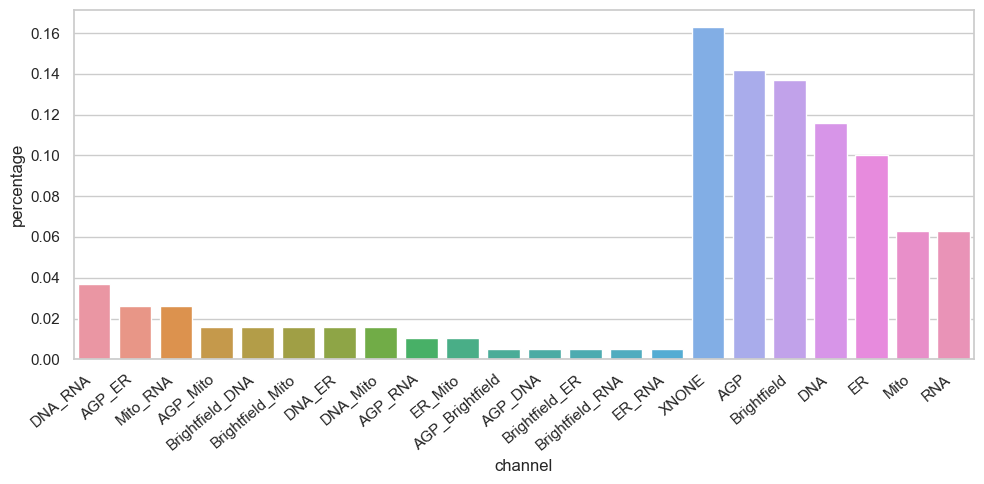

In [83]:
#plot each category of channel based on percentage
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

#convert channel_list to a dataframe
df_channel=pd.DataFrame(channel_list,columns=['channel'])

#count the number of each category
df_channel_count=df_channel.groupby('channel').size().reset_index(name='counts')

#calculate the percentage of each category
df_channel_count['percentage']=df_channel_count['counts']/df_channel_count['counts'].sum()

#sort channel column based on whether it has a specific string "_"
df_channel_count['sort']=df_channel_count['channel'].str.contains('_')
#sort df_channel_count based on the sort column
df_channel_count=df_channel_count.sort_values(by=['sort','percentage'],ascending=False)
#plot the percentage of each category
plt.figure(figsize=(10,5))
ax = sns.barplot(x="channel", y="percentage", data=df_channel_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()
